In [1]:
from itertools import islice

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch

import torch.nn as nn
import torchvision


def train(params):
    messiness = params[0]
    alpha = params[1]
    
    steps = 10000
    
    templates = torch.linspace(-0.5,0.5,steps=10).unsqueeze(dim=1).unsqueeze(dim=1).unsqueeze(dim=1) * torch.ones(10,1,28,28)
    
    def cycle(iterable):
        while True:
            for x in iterable:
                yield x
            
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    
    #train = torchvision.datasets.MNIST(root="/tmp", train=True, transform=torchvision.transforms.ToTensor(), download=True)
    #test = torchvision.datasets.MNIST(root="/tmp", train=False, transform=torchvision.transforms.ToTensor(), download=True)
    #train_loader = torch.utils.data.DataLoader(train, batch_size=50, shuffle=True)
    
    def accuracy(network, dataset, device, N=2000, batch_size=50):
        dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        correct = 0
        total = 0
        for x, labels in islice(dataset_loader, N // batch_size):
            x = messiness * x + (1-messiness) * templates[labels]
            logits = network(x.to(device))
            predicted_labels = torch.argmax(logits, dim=1)
            correct += torch.sum(predicted_labels == labels.to(device))
            total += x.size(0)
        return correct / total
    
    def loss_f(network, dataset, device, N=2000, batch_size=50):
        dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        loss = 0
        total = 0
        for x, labels in islice(dataset_loader, N // batch_size):
            x = messiness * x + (1-messiness) * templates[labels]
            logits = network(x.to(device))
            loss += torch.sum((logits-torch.eye(10,)[labels])**2)
            total += x.size(0)
        return loss / total

    train = torchvision.datasets.MNIST(root="/tmp", train=True, transform=torchvision.transforms.ToTensor(), download=True)
    test = torchvision.datasets.MNIST(root="/tmp", train=False, transform=torchvision.transforms.ToTensor(), download=True)

    data_size = 60000 #data_size
    train = torch.utils.data.Subset(train, range(data_size))
    train_loader = torch.utils.data.DataLoader(train, batch_size=100, shuffle=True)
    
    def L2(model):
        L2_ = 0.
        for p in mlp.parameters():
            L2_ += torch.sum(p**2)
        return L2_

    def rescale(model, alpha):
        for p in mlp.parameters():
            p.data = alpha * p.data
            
            
    width = 200
    mlp = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, width),
        nn.ReLU(),
        nn.Linear(width, width),
        nn.ReLU(),
        nn.Linear(width, 10)
    ).to(device)

    rescale(mlp, alpha)
    L2_ = L2(mlp)
    
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.AdamW(mlp.parameters(), lr=1e-3, weight_decay=0.0)
    
    one_hots = torch.eye(10, 10).to(device)
    
    mlp.eval()
    print("Initial accuracy: {0:.4f}".format(accuracy(mlp, test, device)))

    test_accuracies = []
    train_accuracies = []

    i = 0
    mlp.train()
    pbar = tqdm(islice(cycle(train_loader), steps), total=steps)
    
    best_train_loss = 1e4
    best_test_loss = 1e4
    best_train_acc = 0.
    best_test_acc = 0.
    
    for x, label in pbar:
        #print(x)
        #print(templates)
        x = messiness * x + (1-messiness) * templates[label]
        #print(templates[label].shape)
        #print(torch.norm(x), torch.norm(templates[label]))
        mlp.train()
        optimizer.zero_grad()
        loss_train = loss_fn(mlp(x.to(device)), one_hots[label])
        loss_train.backward()
        optimizer.step()
        L2_new = L2(mlp)
        # rescale weights such that the weight norm remains a constant in training.
        rescale(mlp, torch.sqrt(L2_/L2_new))
        if i % 50 == 0:
            with torch.no_grad():
                mlp.eval()
                train_acc = accuracy(mlp, train, device).item()
                test_acc = accuracy(mlp, test, device).item()
                train_loss = loss_f(mlp, train, device).item()
                test_loss = loss_f(mlp, test, device).item()
                #train_accuracies.append(train_acc)
                #test_accuracies.append(test_acc)
                if train_acc > best_train_acc:
                    best_train_acc = train_acc
                if test_acc > best_test_acc:
                    best_test_acc = test_acc
                if train_loss < best_train_loss:
                    best_train_loss = train_loss
                if test_loss < best_test_loss:
                    best_test_loss = test_loss
                mlp.train()
                pbar.set_description("{:3.3f} | {:3.3f} | {:3.3f} | {:3.3f}".format(train_acc, test_acc, train_loss, test_loss))
        i += 1
    np.savetxt("./mnist_landscape_rep/trainacc_%.2f_%.4f.txt"%(messiness, alpha), np.array([best_train_acc]))
    np.savetxt("./mnist_landscape_rep/testacc_%.2f_%.4f.txt"%(messiness, alpha), np.array([best_test_acc]))
    np.savetxt("./mnist_landscape_rep/trainloss_%.2f_%.4f.txt"%(messiness, alpha), np.array([best_train_loss]))
    np.savetxt("./mnist_landscape_rep/testloss_%.2f_%.4f.txt"%(messiness, alpha), np.array([best_test_loss]))
    


In [3]:
import numpy as np
#messys = np.linspace(0,1,num=11)
#alphas = 10**np.linspace(-1,1,num=11)

messys = np.linspace(0,1,num=21)
alphas = np.linspace(0,10,num=21)


xx, yy = np.meshgrid(messys, alphas)
params = list(np.transpose(np.array([xx.reshape(-1,), yy.reshape(-1,)])))

from multiprocess import Pool

if __name__ == '__main__':
    with Pool(11) as p:
        print(p.map(train, params))

Initial accuracy: 0.1015Initial accuracy: 0.1015

Initial accuracy: 0.2120Initial accuracy: 0.0830Initial accuracy: 0.1015
Initial accuracy: 0.0830


Initial accuracy: 0.2115Initial accuracy: 0.1015
Initial accuracy: 0.1040Initial accuracy: 0.1010


Initial accuracy: 0.2080


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0050
Initial accuracy: 0.0885


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0845
Initial accuracy: 0.0690
Initial accuracy: 0.0330


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0095


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0000
Initial accuracy: 0.0885


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0495


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0630


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0000


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0965


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1025


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1005


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0785Initial accuracy: 0.1055

Initial accuracy: 0.1025


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0850


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1060


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1145


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1045


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.2075


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0930


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0930


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0660


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1075


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0800


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0260


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0585


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0230


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0455


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0780


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0740


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0840
Initial accuracy: 0.0950
Initial accuracy: 0.0950
Initial accuracy: 0.0940


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0880


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0785


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0775
Initial accuracy: 0.0960


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0730


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0680


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0940


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0975
Initial accuracy: 0.0975


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1060
Initial accuracy: 0.0640


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0740


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0845


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0945


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1060


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0965


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1030


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1060


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1010


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0945


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0945


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1010


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1015


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1065


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1010


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1015
Initial accuracy: 0.1035


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1010


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1010


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0920


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0330


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0920


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0835


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0875


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0790


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0825
Initial accuracy: 0.0725


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0730


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0715


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0875


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0860


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0865


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0865


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1060


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0915


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1305


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1730


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1440


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0915


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1455


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1025


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1025


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0875


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1025


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0350


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0960


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1105
Initial accuracy: 0.1240Initial accuracy: 0.0575

Initial accuracy: 0.0965


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0120


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0965


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1060


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1795


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0810


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0815


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.2190


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.2555
Initial accuracy: 0.1095


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1165


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0980


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0990


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1810


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0560


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0345


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0540


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0325


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0550


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0305


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0565


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0295


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0590


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0285


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0960


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1245


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0690


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1275


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0680


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1310


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0760
Initial accuracy: 0.0935
Initial accuracy: 0.0860


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1315


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0940


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0935


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0695
Initial accuracy: 0.0435


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0720


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0395


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0745


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0000
Initial accuracy: 0.0320
Initial accuracy: 0.0360


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0000


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0345


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0000


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0910


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1195


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0940


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1090


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1040


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1065
Initial accuracy: 0.1015
Initial accuracy: 0.1040


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1045


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0950


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1250


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0725


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1140


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.2020


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0885


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1760


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1325
Initial accuracy: 0.1240


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0915
Initial accuracy: 0.0965


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0965


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1215


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1125


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.2025


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1600


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.2045


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1985


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.2025


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1975


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.2065


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.2120


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1965


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.2145


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.2115


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0945


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.2115


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0965


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.2070


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1555
Initial accuracy: 0.0915


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1915


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0930


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0920


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1300


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.2015


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1745


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.2060


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1720


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1455


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.2070


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1605


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1960


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1855


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1380


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1750


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1110


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1115


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1095


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1010


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0930


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1095


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0970


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1080
Initial accuracy: 0.1100


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0875


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1095


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0605


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1045


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0690


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1040


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0820


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1095


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1055


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0960


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0905


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1115


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0980


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0980


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1145


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1020


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1215


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1260


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1085


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1255


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1185


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1145


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1260


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1130


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0660


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1820


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0640


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1795


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0650


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1780


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0630


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1605


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0640


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1340


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0645


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0365


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0000


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0000
Initial accuracy: 0.0400


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0420


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0000


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0430


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0000


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0430


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0005


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0495


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0895


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0365


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0475


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0935


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0890


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0530


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0490
Initial accuracy: 0.0915


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0960


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0535


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1045


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0540


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0070


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0095


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0545


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0545


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0540


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0145


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0245


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0535


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0330


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0550


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1605


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.2050


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1430


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.2045


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.2015


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1500


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1560


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.2010


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1390


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1985


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1330


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1015


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1350


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0890Initial accuracy: 0.1370



  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0965
Initial accuracy: 0.1375


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0985
Initial accuracy: 0.1320


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0860


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1275


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1115


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1070


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1035


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1045
Initial accuracy: 0.1065


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1050


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1045


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1070


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1075


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1025


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1065


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1025


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0545


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0805


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0505


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0655
Initial accuracy: 0.2260


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0715


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0540


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0610


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.2260


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0555


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.2150


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0825


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0715


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0745
Initial accuracy: 0.0000


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0725


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0000


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0720


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0895


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0005


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0700


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0035


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1045


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1665


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.2140Initial accuracy: 0.1575



  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.2140
Initial accuracy: 0.1535


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1490


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.2140


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.2155


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1415


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.2155


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0000


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0750


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0750


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0750
Initial accuracy: 0.0740


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0895


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0165
Initial accuracy: 0.0740


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1030


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0755


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1010


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0580


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0695


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0580


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0590Initial accuracy: 0.0820



  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0850


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0645


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0910


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1105


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1095


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0765
Initial accuracy: 0.0815


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0955


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0770


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0855


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0740


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0975


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0695


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0885


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0665


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0965


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0610


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0625


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0705


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0960


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0915


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0730


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0975


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0775


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1060


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1015


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1030


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1030


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1030


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1030


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1030


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1200


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1220


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0535


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0470
Initial accuracy: 0.1305


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0245


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1365


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0675


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0700


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0705


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0570


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0555


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0555


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0755


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0720


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0710


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0705


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0765


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0795


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0815


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0700


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1005


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0920


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0845


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1425


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1515


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0800


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1430


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1515


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1630


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1740


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0360


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1745


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0320


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.0310


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1655


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1545


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1410


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1260


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1890


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1825


  0%|          | 0/10000 [00:00<?, ?it/s]

Initial accuracy: 0.1650


  0%|          | 0/10000 [00:00<?, ?it/s]

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, Non

/Users/ziming/opt/anaconda3/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/ziming/opt/anaconda3/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/ziming/opt/anaconda3/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/ziming/opt/anaconda3/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/ziming/opt/anaconda3/

In [21]:
import numpy as np
import matplotlib.pyplot as plt

#messys = np.linspace(0,1,num=11)
#scales = 10**np.linspace(-1,1,num=11)
messys = np.linspace(0,1,num=21)
scales = np.linspace(0,10,num=21)

train_accss = []
test_accss = []
train_lossss = []
test_lossss = []

for messiness in messys:
    train_accs = []
    test_accs = []
    train_losss = []
    test_losss = []
    for alpha in scales:
        train_acc = np.loadtxt("./mnist_landscape_rep/trainacc_%.2f_%.4f.txt"%(messiness, alpha))
        test_acc = np.loadtxt("./mnist_landscape_rep/testacc_%.2f_%.4f.txt"%(messiness, alpha))
        train_loss = np.loadtxt("./mnist_landscape_rep/trainloss_%.2f_%.4f.txt"%(messiness, alpha))
        test_loss = np.loadtxt("./mnist_landscape_rep/testloss_%.2f_%.4f.txt"%(messiness, alpha))
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        train_losss.append(train_loss)
        test_losss.append(test_loss)
    train_accss.append(train_accs)
    test_accss.append(test_accs)
    train_lossss.append(train_losss)
    test_lossss.append(test_losss)
    
train_accss = np.array(train_accss)
test_accss = np.array(test_accss)
train_lossss = np.array(train_lossss)
test_lossss = np.array(test_lossss)



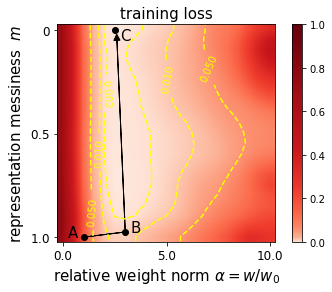

In [84]:
#plt.figure(figsize=(20,10))
from scipy.ndimage.filters import gaussian_filter
import matplotlib.colors as mcolors
import torch

class MyNormalize(mcolors.Normalize):
    def __call__(self, value, clip=None):
        # function to normalize any input between vmin and vmax linearly to [0,1]
        n = lambda x: (x-self.vmin)/(self.vmax-self.vmin)
        # nonlinear function between [0,1] and [0,1]
        f = lambda x: x**(1/3)
        return np.ma.masked_array(f(n(value)))
    
norm = MyNormalize(vmin=0, vmax=1.0)

plot_scale = ps = 10

method = "bilinear"

blur = gaussian_filter(np.array(train_lossss)[:,:], sigma=1)
train_large = torch.nn.functional.interpolate(torch.tensor(blur).unsqueeze(dim=0).unsqueeze(dim=0), scale_factor=(plot_scale,plot_scale), mode=method)[0,0].detach().numpy()

x = np.arange(21*plot_scale)
y = np.arange(21*plot_scale)
X, Y = np.meshgrid(x, y)
CS = plt.gca().contour(X, Y, train_large, [0.002,0.01,0.05], colors=["yellow","yellow"], linestyles=["dashed", "dashed"])
plt.gca().clabel(CS, inline=True, fontsize=10)
#plt.imshow((gaussian_filter(np.array(trainss)[:10,6:12], sigma=1)), cmap='Reds', norm=norm)
#plt.imshow((gaussian_filter(np.array(trainss)[:,:], sigma=1)), cmap='Reds', norm=norm)
plt.imshow(train_large, cmap='Reds', norm=norm)


plt.colorbar()
#plt.clim(0,0.5)
plt.xlabel('relative weight norm '+ r"$\alpha=w/w_0$", fontsize=15)
plt.ylabel('representation messiness  '+r"$m$", fontsize=15)
plt.xticks([0.5*ps,10.5*ps,20.5*ps],[scales[0], scales[10], scales[20]], fontsize=12)
plt.yticks([0.5*ps,10.5*ps,20.5*ps],[r"$0$", r"$0.5$",r"$1.0$"], fontsize=12)
#plt.yticks([0,10],[0,1], rotation=90)

A = np.array([2.5,20.5])*ps
B = np.array([6.5,20.0])*ps
C = np.array([5.5,0.5])*ps
plt.scatter(A[0], A[1], color="black")
plt.scatter(B[0], B[1], color="black")
plt.scatter(C[0], C[1], color="black")
plt.arrow(A[0], A[1], B[0]-A[0], B[1]-A[1])
plt.arrow(B[0], B[1], C[0]-B[0]+0.2*ps, C[1]-B[1]+1.0*ps, head_width=6,head_length=6,color="black")
plt.text(A[0]-1.5*ps, A[1], "A", fontsize=15)
plt.text(B[0]+0.5*ps, B[1], "B", fontsize=15)
plt.text(C[0]+0.5*ps, C[1]+1.0*ps, "C", fontsize=15)


plt.title("training loss", fontsize=15)
plt.savefig('./mnist_train_loss_repr.pdf', bbox_inches="tight")

/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


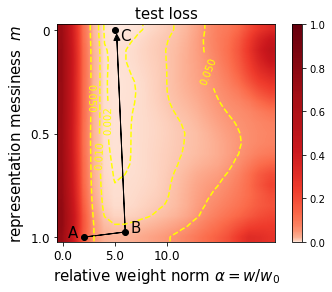

In [85]:
#plt.figure(figsize=(20,10))
from scipy.ndimage.filters import gaussian_filter
import matplotlib.colors as mcolors
import torch

class MyNormalize(mcolors.Normalize):
    def __call__(self, value, clip=None):
        # function to normalize any input between vmin and vmax linearly to [0,1]
        n = lambda x: (x-self.vmin)/(self.vmax-self.vmin)
        # nonlinear function between [0,1] and [0,1]
        f = lambda x: x**(1/3)
        return np.ma.masked_array(f(n(value)))
    
norm = MyNormalize(vmin=0, vmax=1.0)

plot_scale = ps = 10

blur = gaussian_filter(np.array(test_lossss)[:,:], sigma=1)
test_large = torch.nn.functional.interpolate(torch.tensor(blur).unsqueeze(dim=0).unsqueeze(dim=0), scale_factor=(plot_scale,plot_scale), mode=method)[0,0].detach().numpy()

x = np.arange(21*plot_scale)
y = np.arange(21*plot_scale)
X, Y = np.meshgrid(x, y)
CS = plt.gca().contour(X, Y, test_large, [0.002,0.01,0.05], colors=["yellow","yellow"], linestyles=["dashed", "dashed"])
plt.gca().clabel(CS, inline=True, fontsize=10)
#plt.imshow((gaussian_filter(np.array(trainss)[:10,6:12], sigma=1)), cmap='Reds', norm=norm)
#plt.imshow((gaussian_filter(np.array(trainss)[:,:], sigma=1)), cmap='Reds', norm=norm)
plt.imshow(test_large, cmap='Reds', norm=norm)


plt.colorbar()
#plt.clim(0,0.5)
plt.xlabel('relative weight norm '+ r"$\alpha=w/w_0$", fontsize=15)
plt.ylabel('representation messiness  '+r"$m$", fontsize=15)
plt.xticks([0.5*ps,5.5*ps,10.5*ps],[scales[0], scales[10], scales[20]], fontsize=12)
plt.yticks([0.5*ps,10.5*ps,20.5*ps],[r"$0$", r"$0.5$",r"$1.0$"], fontsize=12)
#plt.yticks([0,10],[0,1], rotation=90)

plt.scatter(A[0], A[1], color="black")
plt.scatter(B[0], B[1], color="black")
plt.scatter(C[0], C[1], color="black")
plt.arrow(A[0], A[1], B[0]-A[0], B[1]-A[1])
plt.arrow(B[0], B[1], C[0]-B[0]+0.2*ps, C[1]-B[1]+1.0*ps, head_width=6,head_length=6,color="black")
plt.text(A[0]-1.5*ps, A[1], "A", fontsize=15)
plt.text(B[0]+0.5*ps, B[1], "B", fontsize=15)
plt.text(C[0]+0.5*ps, C[1]+1.0*ps, "C", fontsize=15)


plt.title("test loss", fontsize=15)

plt.savefig('./mnist_test_loss_repr.pdf', bbox_inches="tight")

In [86]:
from scipy import interpolate
from scipy.interpolate import griddata

def interp(A, B, num=101):
    xs = np.linspace(A[0], B[0], num=num)
    ys = np.linspace(A[1], B[1], num=num)
    return np.array([xs, ys])

traj = np.concatenate([interp(A, B, num=300), interp(B, C, num=700)], axis=1)
x_ = traj[0]
y_ = traj[1]

X_, Y_ = np.meshgrid(x_, y_)


f_train = griddata(np.transpose(np.array([X.reshape(-1,), Y.reshape(-1,)])), train_large.reshape(-1,), (X_, Y_), method='cubic')
f_test = griddata(np.transpose(np.array([X.reshape(-1,), Y.reshape(-1,)])), test_large.reshape(-1,), (X_, Y_), method='cubic')



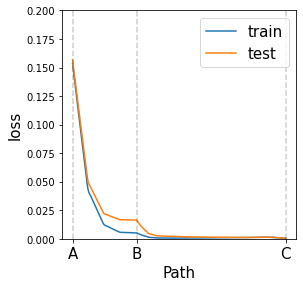

In [88]:
plt.figure(figsize=(4.2,4.2))

plt.plot(f_train.diagonal())
plt.plot(f_test.diagonal())
plt.xticks([0,300,999], ["A", "B", "C"], fontsize=15);
plt.xlabel('Path', fontsize=15)
plt.ylabel('loss', fontsize=15)
plt.legend(["train", "test"], fontsize=15)
plt.plot([0,0],[0,2.0],color="black",alpha=0.2,ls="--")
plt.plot([300,300],[0,2.0],color="black",alpha=0.2,ls="--")
plt.plot([999,999],[0,2.0],color="black",alpha=0.2,ls="--")

plt.ylim(0,0.2)

plt.savefig("./mnist_loss_path.pdf", bbox_inches="tight")